## Load the data

In [ ]:
import warnings
warnings.filterwarnings('always')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
features = np.load('../development.npy')
metadata = pd.read_csv('../modified_development.csv')
feature_names = pd.read_csv('../metadata/idx_to_feature_name.csv')
# labels = metadata['label']

# Showing the first few rows to verify the labels have been added correctly
print(metadata.head())

features.shape

   id                 filename  speaker_id         word               label
0   0     words/Brötchen/1.wav           1     Brötchen   Non-command Words
1   1         words/kann/1.wav           1         kann   Sound-alike Words
2   2  words/Staubsauger/1.wav           1  Staubsauger  Smart Home Devices
3   3      words/Spiegel/1.wav           1      Spiegel   Non-command Words
4   4        words/Alarm/1.wav           1        Alarm  Smart Home Devices


(45296, 175, 44)

## Encoding for SVM

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Defined classes and one additional class for 'other'
classes = ["Fernseher", "Heizung", "Licht", "Lüftung", "Ofen", "Alarm", "Radio", "Staubsauger", "an", "aus", "other"]

# Map all non-specified labels to 'other'
metadata['encoded_label'] = metadata['word'].apply(lambda x: x if x in classes else 'other')
print(metadata.head())

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder to your classes including 'other'
label_encoder.fit(classes)

# Transform labels to integers
metadata['encoded_label'] = label_encoder.transform(metadata['encoded_label'])

# Check the encoded labels
print(metadata[['word', 'encoded_label']])


   id                 filename  speaker_id         word               label  \
0   0     words/Brötchen/1.wav           1     Brötchen   Non-command Words   
1   1         words/kann/1.wav           1         kann   Sound-alike Words   
2   2  words/Staubsauger/1.wav           1  Staubsauger  Smart Home Devices   
3   3      words/Spiegel/1.wav           1      Spiegel   Non-command Words   
4   4        words/Alarm/1.wav           1        Alarm  Smart Home Devices   

  encoded_label  
0         other  
1         other  
2   Staubsauger  
3         other  
4         Alarm  
              word  encoded_label
0         Brötchen             10
1             kann             10
2      Staubsauger              7
3          Spiegel             10
4            Alarm              0
...            ...            ...
45291        other             10
45292        other             10
45293        other             10
45294        other             10
45295        other             10

[45296 r

In [ ]:
labels[0]

10

In [ ]:
feature_names

,index,feature_name
0,0,bandwidth_0
1,1,centroid_0
2,2,contrast_0
3,3,contrast_1
4,4,contrast_2
...,...,...
170,170,mfcc_d2_30
171,171,mfcc_d2_31
172,172,power_0
173,173,yin_0


## Shuffle the Data

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate shuffled indices
shuffled_indices = np.random.permutation(len(features))

# Apply shuffled indices to both features and metadata
features = features[shuffled_indices]
metadata = metadata.iloc[shuffled_indices].reset_index(drop=True)
print(metadata.head())

# Extract labels
labels = metadata['encoded_label'].values

      id                            filename  speaker_id     word  \
0  28032                 words/Ofen/2093.wav          39     Ofen   
1  38072              words/Lüftung/2849.wav         103  Lüftung   
2   4967                  words/Haus/399.wav         101     Haus   
3  42778  words/other/409_10_speech_true.wav         233    other   
4   5792                 words/Radio/471.wav         119    Radio   

                label  encoded_label  
0  Smart Home Devices              5  
1  Smart Home Devices              4  
2   Sound-alike Words             10  
3        Other Sounds             10  
4  Smart Home Devices              6  


## Identify highly correlated features and remove them

In [ ]:
# Number of samples, features, and frames
num_samples, num_features, num_frames =features.shape

# Calculate the mean correlation coefficients across time frames
mean_correlations = np.zeros((num_features, num_features))  # Placeholder for mean correlations

for i in range(num_features):
    for j in range(i+1, num_features):
        temp_corr = [np.corrcoef(features[:, i, t], features[:, j, t])[0, 1] for t in range(num_frames)]
        mean_correlations[i, j] = mean_correlations[j, i] = np.mean(temp_corr)

# Convert to DataFrame for easier manipulation
corr_matrix = pd.DataFrame(mean_correlations)

# Set the threshold
threshold = 0.8

# Find indices where correlation is high
high_corr = np.where((corr_matrix > threshold) & (corr_matrix != 1.0))

# Extract pairs
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr) if x < y]



In [ ]:
high_corr_pairs
# corr_matrix.shape
# mean_correlations.shape

[(0, 1),
 (1, 174),
 (12, 13),
 (13, 14),
 (13, 15),
 (13, 16),
 (13, 17),
 (13, 18),
 (13, 19),
 (14, 15),
 (14, 16),
 (14, 17),
 (14, 18),
 (14, 19),
 (14, 20),
 (15, 16),
 (15, 17),
 (15, 18),
 (15, 19),
 (15, 20),
 (15, 21),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (16, 21),
 (17, 18),
 (17, 19),
 (17, 20),
 (17, 21),
 (17, 22),
 (17, 23),
 (18, 19),
 (18, 20),
 (18, 21),
 (18, 22),
 (18, 23),
 (18, 24),
 (19, 20),
 (19, 21),
 (19, 22),
 (19, 23),
 (19, 24),
 (19, 25),
 (19, 26),
 (19, 76),
 (20, 21),
 (20, 22),
 (20, 23),
 (20, 24),
 (20, 25),
 (20, 26),
 (20, 27),
 (20, 28),
 (20, 76),
 (21, 22),
 (21, 23),
 (21, 24),
 (21, 25),
 (21, 26),
 (21, 27),
 (21, 28),
 (21, 29),
 (21, 30),
 (21, 31),
 (21, 76),
 (22, 23),
 (22, 24),
 (22, 25),
 (22, 26),
 (22, 27),
 (22, 28),
 (22, 29),
 (22, 30),
 (22, 31),
 (22, 32),
 (22, 33),
 (22, 76),
 (23, 24),
 (23, 25),
 (23, 26),
 (23, 27),
 (23, 28),
 (23, 29),
 (23, 30),
 (23, 31),
 (23, 32),
 (23, 33),
 (23, 34),
 (23, 35),
 (23, 76),
 

In [ ]:
# Flatten the list of pairs and count frequency
from collections import Counter
all_features = [item for sublist in high_corr_pairs for item in sublist]
count = Counter(all_features)

# Remove features that appear most frequently
to_remove = {item for item, freq in count.items() if freq > 1}

# New list without highly correlated features
remaining_features = [col for col in corr_matrix.columns if col not in to_remove]


In [ ]:
remaining_features

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174]

In [ ]:
# Assuming the original feature set is in a DataFrame or similar structure
filtered_features = features[:, remaining_features, :]


In [ ]:
# filtered_features.shape
filtered_feature_names = feature_names.loc[remaining_features, 'feature_name'].tolist()
filtered_feature_names

['bandwidth_0',
 'contrast_0',
 'contrast_1',
 'contrast_2',
 'contrast_3',
 'contrast_4',
 'contrast_5',
 'contrast_6',
 'energy_0',
 'flatness_0',
 'flux_0',
 'melspect_0',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24',
 'mfcc_25',
 'mfcc_26',
 'mfcc_27',
 'mfcc_28',
 'mfcc_29',
 'mfcc_30',
 'mfcc_31',
 'mfcc_d_0',
 'mfcc_d_1',
 'mfcc_d_2',
 'mfcc_d_3',
 'mfcc_d_4',
 'mfcc_d_5',
 'mfcc_d_6',
 'mfcc_d_7',
 'mfcc_d_8',
 'mfcc_d_9',
 'mfcc_d_10',
 'mfcc_d_11',
 'mfcc_d_12',
 'mfcc_d_13',
 'mfcc_d_14',
 'mfcc_d_15',
 'mfcc_d_16',
 'mfcc_d_17',
 'mfcc_d_18',
 'mfcc_d_19',
 'mfcc_d_20',
 'mfcc_d_21',
 'mfcc_d_22',
 'mfcc_d_23',
 'mfcc_d_24',
 'mfcc_d_25',
 'mfcc_d_26',
 'mfcc_d_27',
 'mfcc_d_28',
 'mfcc_d_29',
 'mfcc_d_30',
 'mfcc_d_31',
 'mfcc_d2_0',
 'mfcc_d2_

## Filtering Most Important Features

In [ ]:
feature_name_to_index = dict(zip(feature_names['feature_name'], feature_names['index']))
important_features = [
    'mfcc_3', 'power_0', 'mfcc_4', 'zcr_0', 'mfcc_1',
    'mfcc_d_0', 'energy_0', 'centroid_0', 'flux_0', 'mean_contrast','contrast_0', 'contrast_1', 'contrast_2', 'contrast_3',
    'contrast_4', 'contrast_5', 'contrast_6'
]

important_indices = [feature_name_to_index[feat] for feat in important_features if feat in feature_name_to_index]
imp_features = features[:, important_indices, :]

# # List of contrast features
# contrast_features = [
#     'contrast_0', 'contrast_1', 'contrast_2', 'contrast_3',
#     'contrast_4', 'contrast_5', 'contrast_6'
# ]
# Get indices of the contrast features
# contrast_indices = [feature_name_to_index[feat] for feat in contrast_features if feat in feature_name_to_index]

# contrast_data = features[:, contrast_indices, :]
# Calculate the mean across the contrast feature axis
# mean_contrast = np.mean(contrast_data, axis=1)

# mean_contrast = mean_contrast[:, np.newaxis, :]  # Add a new axis if needed for consistency

# Combine important features with mean contrast
# Check dimensions and concatenate along the feature axis (axis=1)
# if mean_contrast.shape[-1] == imp_features.shape[-1]:
#     combined_imp_features = np.concatenate((imp_features, mean_contrast), axis=1)
# else:
#     print("Error: Dimension mismatch.")

In [ ]:
important_feature_names = feature_names.loc[important_indices, 'feature_name'].tolist()
important_feature_names

['mfcc_3',
 'power_0',
 'mfcc_4',
 'zcr_0',
 'mfcc_1',
 'mfcc_d_0',
 'energy_0',
 'centroid_0',
 'flux_0',
 'contrast_0',
 'contrast_1',
 'contrast_2',
 'contrast_3',
 'contrast_4',
 'contrast_5',
 'contrast_6']

## Reshape and Split the Feature Data

In [ ]:
# Reshape features to collapse the time frames into feature statistics (mean here as example)
features_imp_2d = np.mean(imp_features, axis=2)  # Now features_imp_2d has shape (45000, 10)
features_imp_2d.shape

features_filtered_2d = np.mean(filtered_features, axis=2)
features_filtered_2d.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Number of samples, features, and frames
# num_samples, num_features, num_frames = combined_imp_features.shape

# Reshape the features to flatten the features and frames into one dimension
# X_flattened = combined_imp_features.reshape(num_samples, num_features * num_frames)


# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_filtered_2d, labels, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sample a subset of the training data
subset_indices = np.random.choice(X_train.shape[0], size=int(X_train.shape[0] * 0.4), replace=False)
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]


## Grid Search and Evaluation
### To fine tune hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

In [ ]:

# param_grid = {
#     'C': [0.1, 1, 10,],
#     'gamma': [0.001, 0.01, 0.1, 1],
#     'kernel': ['rbf', 'poly', 'linear']
# }

# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
# grid_search.fit(X_train_subset, y_train_subset)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  14.0s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  14.2s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  14.1s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.548 total time=  13.5s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.548 total time=  14.2s
[CV 1/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.547 total time=  11.5s
[CV 2/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.545 total time=  11.5s
[CV 3/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.546 total time=  11.5s
[CV 4/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.547 total time=  11.5s
[CV 5/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.548 total time=  13.1s
[CV 1/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.546 total time=  32.5s
[CV 2/5] END .C=0.1, gamma=0.001, kernel=linear

[CV 2/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.545 total time= 4.6min
[CV 3/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.544 total time= 3.4min
[CV 4/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.545 total time= 3.4min
[CV 5/5] END .....C=1, gamma=0.1, kernel=linear;, score=0.548 total time= 4.0min
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.546 total time=  25.8s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.547 total time=  26.2s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.547 total time=  25.4s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.548 total time=  26.1s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.548 total time=  26.4s
[CV 1/5] END .........C=1, gamma=1, kernel=poly;, score=0.414 total time=  20.7s
[CV 2/5] END .........C=1, gamma=1, kernel=poly;, score=0.408 total time=  22.0s
[CV 3/5] END .........C=1, gamma=1, kernel=poly;, score=0.415 total time=  18.9s
[CV 4/5] END .........C=1, g

In [ ]:
param_grid = {
    'C': [0.1, 1, 10,100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_train_subset, y_train_subset)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  20.8s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  21.9s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.547 total time=  20.7s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.548 total time=  20.5s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.548 total time=  22.0s
[CV 1/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.547 total time=  19.1s
[CV 2/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.545 total time=  19.3s
[CV 3/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.546 total time=  20.7s
[CV 4/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.547 total time=  21.1s
[CV 5/5] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.548 total time=  20.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.547 total time=  38.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.547 total time=  44.0s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.547 total time=  43.6s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.548 total time=  39.3s
[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.548 total time=  42.4s
[CV 1/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.459 total time=  36.5s
[CV 2/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.454 total time=  40.4s
[CV 3/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.448 total time=  32.0s
[CV 4/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.457 total time=  31.9s
[CV 5/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.460 total time=  31.1s
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.546 total time=  42.3s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.547 total time=  43.6s
[CV 3/5] END .........C=10, gamma=1, kernel=rbf;, score=0.547 total time=  45.6s
[CV 4/5] END .........C=10, 

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=3)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['poly','linear','rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_train_subset, y_train_subset)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.525 total time=   6.5s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.531 total time=   6.8s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.526 total time=   6.8s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.544 total time=   6.4s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.537 total time=   7.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.574 total time=   2.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.570 total time=   2.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.569 total time=   2.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.580 total time=   2.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.578 total time=   2.6s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.551 total time=   7.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.561 total time=   3.9s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.565 total time=   3.9s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.567 total time=   3.9s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.565 total time=   3.9s
[CV 1/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.551 total time=   2.4s
[CV 2/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.550 total time=   2.7s
[CV 3/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.551 total time=   2.5s
[CV 4/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.551 total time=   2.5s
[CV 5/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.551 total time=   3.5s
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.579 total time=   8.3s
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.566 total time=   7.5s
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.573 total time=   8.0s
[CV 4/5] END ...C=1, gamma=0

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'linear', 'rbf']},
             scoring='accuracy', verbose=3)

In [ ]:
param_grid = {
    'C': [2, 4, 6, 8, 10, 12],
    'gamma': [0.01, 0.005, 0.001],
    'kernel': ['rbf']
}

grid_search_full = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search_full.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .......C=2, gamma=0.01, kernel=rbf;, score=0.654 total time= 2.1min
[CV 2/5] END .......C=2, gamma=0.01, kernel=rbf;, score=0.661 total time= 2.3min
[CV 3/5] END .......C=2, gamma=0.01, kernel=rbf;, score=0.663 total time= 2.2min
[CV 4/5] END .......C=2, gamma=0.01, kernel=rbf;, score=0.659 total time= 2.1min
[CV 5/5] END .......C=2, gamma=0.01, kernel=rbf;, score=0.656 total time= 2.3min
[CV 1/5] END ......C=2, gamma=0.005, kernel=rbf;, score=0.632 total time= 1.3min
[CV 2/5] END ......C=2, gamma=0.005, kernel=rbf;, score=0.635 total time= 1.3min
[CV 3/5] END ......C=2, gamma=0.005, kernel=rbf;, score=0.635 total time= 1.3min
[CV 4/5] END ......C=2, gamma=0.005, kernel=rbf;, score=0.634 total time= 1.2min
[CV 5/5] END ......C=2, gamma=0.005, kernel=rbf;, score=0.633 total time= 1.2min
[CV 1/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.570 total time= 1.2min
[CV 2/5] END ......C=2, gamma=0.001, kernel=rbf;

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [2, 4, 6, 8, 10, 12],
                         'gamma': [0.01, 0.005, 0.001], 'kernel': ['rbf']},
             scoring='accuracy', verbose=3)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.59


In [ ]:
print("Best parameters:", grid_search_full.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_full.best_score_))

Best parameters: {'C': 6, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.68


In [ ]:
param_grid = {
    'C': [0.1, 6, 20],
    'gamma': [0.1],
    'kernel': ['rbf']
}

grid_search_full_f1 = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro', verbose=3)
grid_search_full_f1.fit(X_train_subset, y_train_subset)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.551 total time=  30.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.551 total time=  31.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.550 total time=  30.7s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.550 total time=  30.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.550 total time=  30.1s
[CV 1/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.551 total time=  34.2s
[CV 2/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  32.7s
[CV 3/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  33.3s
[CV 4/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.551 total time=  33.0s
[CV 5/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  32.8s
[CV 1/5] END .......C=20, gamma=0.1, kernel=rbf;, score=0.551 total time=  33.2s
[CV 2/5] END .......C=20, gamma=0.1, kernel=rbf;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 6, 20], 'gamma': [0.1], 'kernel': ['rbf']},
             scoring='f1_micro', verbose=3)

In [ ]:
param_grid = {
    'C': [6],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search_full_f1b = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_micro', verbose=3)
grid_search_full_f1b.fit(X_train_subset, y_train_subset)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .......C=6, gamma=0.01, kernel=rbf;, score=0.640 total time=  15.7s
[CV 2/5] END .......C=6, gamma=0.01, kernel=rbf;, score=0.627 total time=  15.3s
[CV 3/5] END .......C=6, gamma=0.01, kernel=rbf;, score=0.617 total time=  15.3s
[CV 4/5] END .......C=6, gamma=0.01, kernel=rbf;, score=0.634 total time=  15.4s
[CV 5/5] END .......C=6, gamma=0.01, kernel=rbf;, score=0.639 total time=  15.5s
[CV 1/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.551 total time=  32.6s
[CV 2/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  35.1s
[CV 3/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  35.2s
[CV 4/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.551 total time=  32.4s
[CV 5/5] END ........C=6, gamma=0.1, kernel=rbf;, score=0.550 total time=  33.4s
[CV 1/5] END ..........C=6, gamma=1, kernel=rbf;, score=0.551 total time=  32.5s
[CV 2/5] END ..........C=6, gamma=1, kernel=rbf;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [6], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='f1_micro', verbose=3)

## Extract Hyperparameter Results and Plot

In [ ]:
results = grid_search_full_f1b.cv_results_

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Filter columns and expand the params column into separate columns
params_df = results_df.loc[:, ['mean_test_score', 'params']].copy()
params_df = pd.concat([params_df.drop(['params'], axis=1), params_df['params'].apply(pd.Series)], axis=1)
params_df.head()

,mean_test_score,C,gamma,kernel
0,0.631572,6,0.01,rbf
1,0.550366,6,0.10,rbf
2,0.550090,6,1.00,rbf


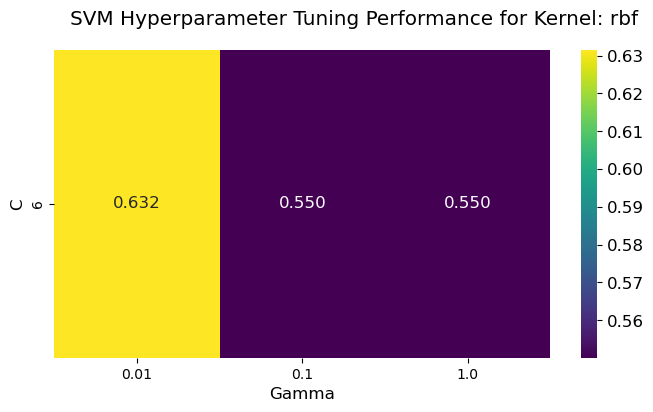

In [ ]:
import matplotlib
# Unique kernels
# kernels = params_df['kernel'].unique()
kernels = params_df['kernel'].unique()[0]

matplotlib.rcParams.update({'font.size': 12, 'axes.titlesize': 14})
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.suptitle('SVM Hyperparameter Tuning Performance for Kernel: ' + kernel)

# Filter data for the kernel
kernel_data = params_df[params_df['kernel'] == kernel]
pivot = kernel_data.pivot(index='C', columns='gamma', values='mean_test_score')

# Plot the heatmap
ax = sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
# ax.set_title('Kernel: ' + kernel)
ax.set_xlabel('Gamma')
ax.set_ylabel('C')

# Increase label size for better readability
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Save the plot if needed
plt.savefig("figures/SVM_Hyperparameter_Tuning_Performance_fullset_f1b.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()

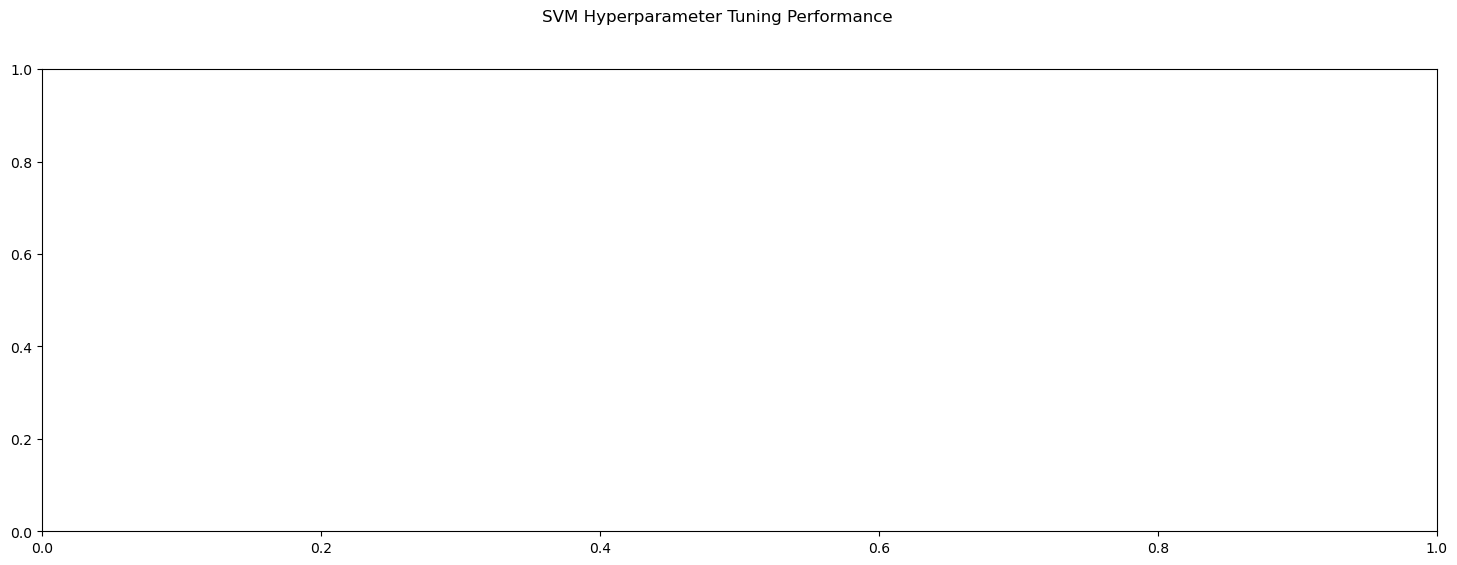

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup plot
fig, axes = plt.subplots(1, len(kernels), figsize=(18, 6), sharey=True)
fig.suptitle('SVM Hyperparameter Tuning Performance')

# Plot each kernel's performance as a heatmap
# for ax, kernel in zip(axes, kernels):
for kernel in kernels:
    # Filter data for the kernel
    kernel_data = params_df[params_df['kernel'] == kernel]
    pivot = kernel_data.pivot(index='C', columns='gamma', values='mean_test_score')
    sns.heatmap(pivot, annot=True, fmt=".3f", ax=ax, cmap='viridis')
    ax.set_title(f'Kernel: {kernel}')
    ax.set_xlabel('Gamma')
    ax.set_ylabel('C')
plt.savefig("figures/SVM_Hyperparameter_Tuning_Performance_fullset.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
# param_grid = {
#     'C': [0.1, 0.5, 1],
#     'gamma': [0.1, 0.5, 1],
#     'kernel': ['rbf']
# }

# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=3)
# grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.547 total time=61.7min


## Randomized Search and Evaluation

In [ ]:
# # Randomized search with cross-validation
# random_search = RandomizedSearchCV(SVC(), param_grid, n_iter=10, cv=5, verbose=3, random_state=42)
# random_search.fit(X_train_subset, y_train_subset)

# # Best parameters and best score
# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(random_search.best_score_))


In [ ]:
# # Alternatively, evaluate the best model found by randomized search
# best_model_random = random_search.best_estimator_
# best_model_random.score(X_test, y_test)

## Define Scoring Metrics

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}


## Perform 5-Fold Cross-Validation

In [ ]:
svm_classifier = SVC(**grid_search.best_params_, max_iter=100, tol=1e-3,verbose=True, random_state=42)
# svm_classifier = SVC(kernel='poly', C=1.0, gamma=1, verbose=True, random_state=42, max_iter=1000, tol=1e-3)  # Experiment with different kernels and C parameter
cv_results = cross_validate(svm_classifier, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

print("Cross-validation results:")
print("Mean Training Accuracy: %0.2f" % np.mean(cv_results['train_accuracy']))
print("Mean Validation Accuracy: %0.2f" % np.mean(cv_results['test_accuracy']))
print("Mean Validation Precision: %0.2f" % np.mean(cv_results['test_precision']))
print("Mean Validation Recall: %0.2f" % np.mean(cv_results['test_recall']))
print("Mean Validation F1 Score: %0.2f" % np.mean(cv_results['test_f1_score']))


## Train SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Support Vector Classifier
# final_svm_classifier = SVC(kernel='rbf', C=1.0, gamma=0.01,verbose=True, random_state=42, max_iter=1000, tol=1e-3)  # Experiment with different kernels and C parameter
final_svm_classifier = SVC(**grid_search_full.best_params_, max_iter=10000, tol=1e-3,verbose=True, random_state=42)


In [ ]:
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    final_svm_classifier.fit(X_train, y_train)

    # Check for convergence warnings
    if any("ConvergenceWarning" in str(warn.message) for warn in w):
        print("Model did not converge. Consider increasing max_iter or adjusting other hyperparameters.")

# Check if it has converged
if hasattr(final_svm_classifier, 'n_iter_'):
    print("Training stopped after", final_svm_classifier.n_iter_, "iterations.")
    converged = final_svm_classifier.n_iter_ < final_svm_classifier.max_iter
else:
    # For some kernels, n_iter_ might not be available.
    converged = "Unknown"

print("Did the model converge?", converged)

# # Train the classifier
# final_svm_classifier.fit(X_train, y_train)


[LibSVM]...*.*
optimization finished, #iter = 4411
obj = -734.021358, rho = 0.369253
nSV = 1764, nBSV = 5
...*..*
optimization finished, #iter = 5190
obj = -923.697747, rho = -0.315665
nSV = 1805, nBSV = 7
.*.*
optimization finished, #iter = 2135
obj = -283.925533, rho = -0.544223
nSV = 850, nBSV = 2
..*.*
optimization finished, #iter = 3715
obj = -586.806269, rho = -0.065327
nSV = 1413, nBSV = 3
...*.*
optimization finished, #iter = 4683
obj = -856.613387, rho = -0.403256
nSV = 1564, nBSV = 5
....*...*
optimization finished, #iter = 7146
obj = -1581.875899, rho = -0.210290
nSV = 2283, nBSV = 19
..*.*
optimization finished, #iter = 3819
obj = -516.749331, rho = 0.674748
nSV = 1765, nBSV = 0
....*...*
optimization finished, #iter = 7098
obj = -1622.343891, rho = -0.563052
nSV = 2019, nBSV = 45
..*.*
optimization finished, #iter = 3359
obj = -528.138904, rho = -0.707442
nSV = 1211, nBSV = 3
.........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -4561.881

In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score

# # Initialize the Support Vector Classifier
# final_svm_classifier = SVC(kernel='poly', C=1.0, gamma=1,verbose=True, random_state=42)  # Experiment with different kernels and C parameter

# # Train the classifier
# final_svm_classifier.fit(X_train, y_train)

# # Predict on the test set
# y_pred = svm_classifier.predict(X_test)


[LibSVM]........................................................................................................................*..........................................................................................................................*................................................................................*
optimization finished, #iter = 321995
obj = -121.235239, rho = 2.083148
nSV = 366, nBSV = 53
...................................*................*
optimization finished, #iter = 51086
obj = -25.378184, rho = -3.733116
nSV = 239, nBSV = 3
............................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

*.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Evaluate the classifier

In [ ]:
# Predict and evaluate on the test set
y_test_pred = final_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')

print("Test Set Evaluation:")
print("Accuracy: %0.2f" % test_accuracy)
print("Precision: %0.2f" % test_precision)
print("Recall: %0.2f" % test_recall)
print("F1 Score: %0.2f" % test_f1)


# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# print("Accuracy Score:")
# print(accuracy_score(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1 Score: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.55      0.65       421
           1       0.83      0.58      0.68       395
           2       0.63      0.31      0.42       391
           3       0.70      0.48      0.57       423
           4       0.64      0.42      0.51       395
           5       0.67      0.33      0.45       417
           6       0.74      0.33      0.45       400
           7       0.94      0.67      0.78       380
           8       0.61      0.35      0.45       403
           9       0.62      0.45      0.52       419
          10       0.69      0.90      0.78      5016

    accuracy                           0.70      9060
   macro avg       0.71      0.49      0.57      9060
weighted avg       0.70      0.70      0.67      9060



In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.ylim([0.4, 1.01])  # You might want to adjust this based on your specific scores
    plt.show()

plot_learning_curves(final_svm_classifier, X_train, y_train, "Learning Curves (SVM)")
# plot_learning_curves(rf_model, X_train_scaled, y_train, "Learning Curves (Random Forest)")


.*
optimization finished, #iter = 487
obj = -97.599565, rho = 0.293193
nSV = 228, nBSV = 0
..*
optimization finished, #iter = 487
obj = -116.216272, rho = -0.310225
nSV = 219, nBSV = 0
*
optimization finished, #iter = 852
obj = -169.537988, rho = 0.292774
nSV = 409, nBSV = 0
*.*
optimization finished, #iter = 351
obj = -55.363540, rho = -0.459797
nSV = 170, nBSV = 0
.*
optimization finished, #iter = 396
obj = -79.760718, rho = -0.185737
nSV = 191, nBSV = 0
.*
optimization finished, #iter = 462
obj = -96.014227, rho = -0.262706
nSV = 209, nBSV = 0
.*.*
optimization finished, #iter = 550
obj = -141.350471, rho = 0.053549
nSV = 249, nBSV = 0
.*
optimization finished, #iter = 447
obj = -82.481015, rho = 0.620053
nSV = 227, nBSV = 0
..*.*
optimization finished, #iter = 549
obj = -154.391256, rho = -0.834719
nSV = 231, nBSV = 3
*
optimization finished, #iter = 924
obj = -194.293225, rho = -0.248636
nSV = 392, nBSV = 0
..*
optimization finished, #iter = 391
obj = -73.119509, rho = -0.631739
n

..*.*
optimization finished, #iter = 1973
obj = -375.936153, rho = 0.969394
nSV = 769, nBSV = 7
.*.*
optimization finished, #iter = 624
obj = -153.950625, rho = 0.365820
nSV = 257, nBSV = 0
*
optimization finished, #iter = 2439
obj = -478.189078, rho = -0.374804
nSV = 897, nBSV = 2
.*
optimization finished, #iter = 433
obj = -76.764865, rho = 0.700831
nSV = 215, nBSV = 0
.*.*
optimization finished, #iter = 555
obj = -140.400134, rho = -0.269964
nSV = 217, nBSV = 1
*..*
optimization finished, #iter = 438
obj = -82.183325, rho = -0.390310
nSV = 189, nBSV = 0
*
optimization finished, #iter = 2400
obj = -400.334342, rho = -0.065502
nSV = 961, nBSV = 1
..*
optimization finished, #iter = 1813
obj = -279.975452, rho = 0.701837
nSV = 878, nBSV = 0
..*.*
optimization finished, #iter = 2138
obj = -454.366997, rho = 1.048945
nSV = 785, nBSV = 10
.*
optimization finished, #iter = 481
obj = -101.569632, rho = 0.536794
nSV = 242, nBSV = 0
.*.*
optimization finished, #iter = 592
obj = -156.036997, rh

..*.*
optimization finished, #iter = 2202
obj = -472.295123, rho = -0.462809
nSV = 884, nBSV = 1
.*
optimization finished, #iter = 1682
obj = -283.734291, rho = 0.287669
nSV = 829, nBSV = 0
.*
optimization finished, #iter = 1544
obj = -293.333675, rho = -0.752114
nSV = 640, nBSV = 2
*.*
optimization finished, #iter = 1225
obj = -186.328168, rho = -0.753091
nSV = 543, nBSV = 0
........*...*
optimization finished, #iter = 5181
obj = -997.163336, rho = 0.925506
nSV = 1815, nBSV = 34
*.*
optimization finished, #iter = 595
obj = -88.983014, rho = -1.079858
nSV = 293, nBSV = 0
.*
optimization finished, #iter = 705
obj = -107.686285, rho = -1.101340
nSV = 332, nBSV = 0
..*....*
optimization finished, #iter = 7335
obj = -1565.203537, rho = 1.246107
nSV = 2242, nBSV = 75
..*.*
optimization finished, #iter = 1589
obj = -362.399881, rho = 0.444951
nSV = 544, nBSV = 5
.*
optimization finished, #iter = 1363
obj = -256.899450, rho = 0.234284
nSV = 490, nBSV = 0
*.*
optimization finished, #iter = 263

....*.*
optimization finished, #iter = 3253
obj = -746.004253, rho = 0.179924
nSV = 1084, nBSV = 9
..*..*
optimization finished, #iter = 4143
obj = -926.303514, rho = -0.702941
nSV = 1502, nBSV = 10
.*
optimization finished, #iter = 1847
obj = -301.660547, rho = 0.877579
nSV = 869, nBSV = 0
.*.*
optimization finished, #iter = 3870
obj = -634.520293, rho = 0.468295
nSV = 1788, nBSV = 2
....*.*
optimization finished, #iter = 2059
obj = -326.267139, rho = -0.801010
nSV = 826, nBSV = 3
.*
optimization finished, #iter = 1319
obj = -261.181317, rho = 0.011373
nSV = 470, nBSV = 1
.*..*
optimization finished, #iter = 2906
obj = -622.654502, rho = -0.048466
nSV = 924, nBSV = 6
..*.*.*
optimization finished, #iter = 4721
obj = -1033.370846, rho = -0.701366
nSV = 1670, nBSV = 14
*
optimization finished, #iter = 2098
obj = -431.946840, rho = -0.410327
nSV = 738, nBSV = 2
...*..*
optimization finished, #iter = 6266
obj = -1813.886269, rho = 1.361157
nSV = 1799, nBSV = 106
*.*
optimization finished,

.*.*
optimization finished, #iter = 2303
obj = -418.870571, rho = 0.103745
nSV = 767, nBSV = 2
.*
optimization finished, #iter = 1652
obj = -289.107756, rho = 0.450848
nSV = 643, nBSV = 3
..*.*
optimization finished, #iter = 1108
obj = -131.542845, rho = 0.973945
nSV = 548, nBSV = 0
*.*.*
optimization finished, #iter = 2766
obj = -451.055480, rho = -0.727337
nSV = 1036, nBSV = 3
*
optimization finished, #iter = 2369
obj = -370.440197, rho = 0.874075
nSV = 1076, nBSV = 0
...*
optimization finished, #iter = 1815
obj = -315.138617, rho = 0.025936
nSV = 632, nBSV = 0
...*
optimization finished, #iter = 1620
obj = -269.553647, rho = -0.125333
nSV = 604, nBSV = 1
..*.*.*
optimization finished, #iter = 4453
obj = -913.351271, rho = -0.474563
nSV = 1697, nBSV = 5
..*.WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
*
optimization finished, #iter = 3783
obj = -816.231158, rho = 0.012787
nSV = 1180, nBSV = 11
obj = -2312.921172, rho = 1.058844
nSV = 3127, nBSV = 103
..*.

/Users/manugupta/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


.........*...*
optimization finished, #iter = 9520
obj = -2783.213013, rho = 1.394745
nSV = 2519, nBSV = 202
..*.*
optimization finished, #iter = 3830
obj = -944.669952, rho = -0.378061
nSV = 1202, nBSV = 19
...*.*
optimization finished, #iter = 3117
obj = -693.717148, rho = 0.031988
nSV = 1139, nBSV = 8
*..WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -2737.438725, rho = 1.208427
nSV = 3069, nBSV = 175
.*
optimization finished, #iter = 1691
obj = -238.301657, rho = 0.718409
nSV = 840, nBSV = 0
.*
optimization finished, #iter = 1926
obj = -324.264601, rho = 0.732898
nSV = 911, nBSV = 0
...*.*.*
optimization finished, #iter = 2909
obj = -613.429997, rho = -0.163697
nSV = 952, nBSV = 10
*
optimization finished, #iter = 2734
obj = -639.465329, rho = -0.300988
nSV = 927, nBSV = 16
.*
optimization finished, #iter = 1589
obj = -273.155427, rho = -0.517441
nSV = 628, nBSV = 1
.*
optimization finished, #iter = 1720
obj = -255.952390, rho = -0.440435
nSV = 669,

KeyboardInterrupt: 